In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scanpy as sc
from matplotlib import rc_context
import anndata as ad
import gc

from collections import Counter
from sklearn.metrics import confusion_matrix
from typing import Tuple, Dict

/home/wu/mambaforge/envs/AutoExtract/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/wu/mambaforge/envs/AutoExtract/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/wu/mambaforge/envs/AutoExtract/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/wu/mambaforge/envs/AutoExtract/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/wu/mambaforge/envs/AutoExtract/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarn

In [2]:
# suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
os.chdir('/home/wu/datb1/AutoExtractSingleCell/AutoExtract_article_new')
sns.set_theme(style="white")

In [4]:
experimental_group_table = pd.read_csv('/home/wu/datb1/AutoExtractSingleCell/scanorama_prior/data/label_change_output/metadata.csv')
experimental_table = pd.read_csv('/home/wu/datb1/AutoExtractSingleCell/scanorama_prior/data/label_change_output/experiment_table.csv')
experimental_group_table.head()

,Group,Dataset,Original Type,New Type,Sample Count,Change Type,Cell Category
0,1,smartseq2,alpha,Alpha cell,1008,Fuzzy match,Endocrine
1,1,celseq2,beta,Unknown,445,Unbiased error,Endocrine
2,1,inDrop3,delta,gamma,161,Biased error,Endocrine
3,2,inDrop3,acinar,Acinar cell,843,Fuzzy match,Exocrine
4,2,inDrop2,alpha,Unknown,676,Unbiased error,Endocrine


In [5]:
import scanpy as sc
import numpy as np
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
import pandas as pd
from typing import List, Dict, Tuple
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_paired_metrics(
    adata: sc.AnnData,
    embedding_leiden_pairs: List[Tuple[str, str]],
    label_key: str
) -> pd.DataFrame:
    
    results = []
    true_labels = adata.obs[label_key]
    
    # Calculate metrics for each embedding-clustering pair
    for emb_key, leiden_key in embedding_leiden_pairs:
        X = adata.obsm[emb_key]
        leiden_labels = adata.obs[leiden_key]
        try:
            sil_score = silhouette_score(X, true_labels)
        except:
            sil_score = np.nan
        ari = adjusted_rand_score(true_labels, leiden_labels)
        nmi = normalized_mutual_info_score(true_labels, leiden_labels)
        
        # Store results
        results.append({
            'embedding': emb_key,
            'clustering': leiden_key,
            'silhouette_score': sil_score,
            'ari': ari,
            'nmi': nmi
        })
    
    return pd.DataFrame(results)

In [6]:
def major_vote_cluster_labels(
    adata: sc.AnnData,
    leiden_key: str,
    changed_label_key: str,
    true_label_key: str
) -> Tuple[pd.Series, pd.DataFrame, Dict]:
    
    cluster_labels = adata.obs[leiden_key]
    changed_labels = adata.obs[changed_label_key]    
    true_labels = adata.obs[true_label_key]
    
    # Perform majority voting for each cluster
    voted_labels = pd.Series(index=adata.obs_names, dtype='object')
    cluster_composition = {}
    
    for cluster in cluster_labels.unique():
        mask = cluster_labels == cluster
        cluster_changed_labels = changed_labels[mask]
        
        label_counts = Counter(cluster_changed_labels)
        majority_label = max(label_counts.items(), key=lambda x: x[1])[0]
        
        voted_labels[mask] = majority_label

        total_cells = len(true_labels)
        composition = {label: count/total_cells for label, count in label_counts.items()}
        cluster_composition[cluster] = composition
    
    adata.obs['voted_labels'] = voted_labels
    
    return adata

In [7]:
merged_metrics = []

for i in range(experimental_table.shape[0]-1):
    raw_adata = sc.read(experimental_table['adata_path'][5])
    adata = sc.read(experimental_table['adata_path'][i])
    changed_cell_type_list = eval(experimental_table['label_changes'][i])
    changed_cell_type_list = [item for sublist in changed_cell_type_list for item in sublist]
    adata_focus = adata[(adata.obs['real_cell_type'].isin(changed_cell_type_list))]
    raw_adata_focus = raw_adata[(raw_adata.obs['real_cell_type'].isin(changed_cell_type_list))]
    embedding_leiden_pairs = [
        ('X_umap_cellhint_raw', 'leiden_cellhint_raw'),
        ('X_umap_cellhint_prior', 'leiden_cellhint_prior'),
        ('X_umap_scanorama_prior_harmonized', 'leiden_scanorama_prior_harmonized'),
        ('X_umap_scanorama_prior_uncorrected', 'leiden_scanorama_prior_uncorrected'),
        ('X_umap_scanorama_raw', 'leiden_scanorama_raw'),
    ]

    metrics = calculate_paired_metrics(
        adata=adata_focus,
        embedding_leiden_pairs=embedding_leiden_pairs,
        label_key='real_cell_type'
    )
    metrics['experiment'] = i+1
    metrics['label_changes'] = True
    raw_metrics = calculate_paired_metrics(
        adata=raw_adata_focus,
        embedding_leiden_pairs=embedding_leiden_pairs,
        label_key='real_cell_type'
    )
    raw_metrics['experiment'] = i+1
    raw_metrics['label_changes'] = False
    
    merged_metrics.append(metrics)
    merged_metrics.append(raw_metrics)

merged_metrics = pd.concat(merged_metrics)

In [8]:
merged_metrics['method'] = merged_metrics['embedding'].apply(lambda x: x.replace('X_umap_', ''))
orders = ['cellhint_raw', 'cellhint_prior', 'scanorama_raw', 'scanorama_prior_uncorrected', 'scanorama_prior_harmonized']

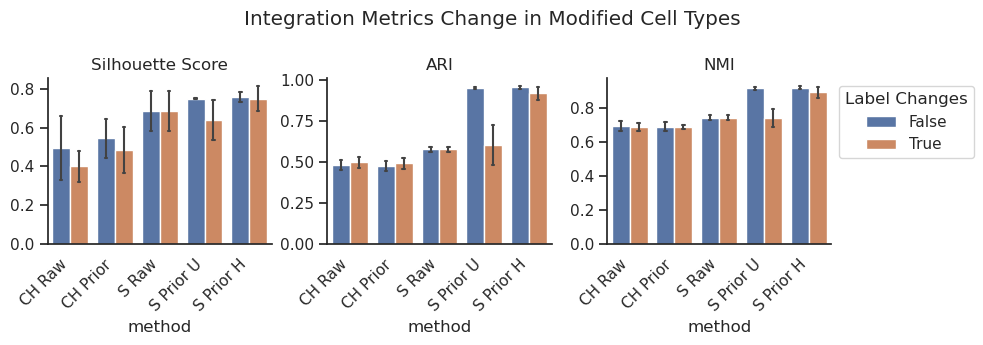

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))
metrics = ['silhouette_score', 'ari', 'nmi']
titles = ['Silhouette Score', 'ARI', 'NMI']
for ax, metric, title in zip(axes, metrics, titles):
    # Create grouped bar plot
    g = sns.barplot(
        data=merged_metrics, x='method', y=metric,
        hue='label_changes', ax=ax, order=orders,
        ci="sd", capsize=0.1, errwidth=1.5, dodge=True)
    g.set_title(title)
    g.set_xticks(range(len(orders)))
    g.set_xticklabels(['CH Raw', 'CH Prior', 'S Raw', 'S Prior U', 'S Prior H'])
    g.set_ylabel('')
    g.legend().remove()
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
    g.yaxis.set_ticks_position('left')
    sns.despine()
    
ax.legend(title='Label Changes', loc='upper left', bbox_to_anchor=(1, 1))
plt.suptitle('Integration Metrics Change in Modified Cell Types')
plt.tight_layout()
plt.savefig('figures/fig4/integration_metrics_change_modified_cell_types.pdf', bbox_inches='tight')

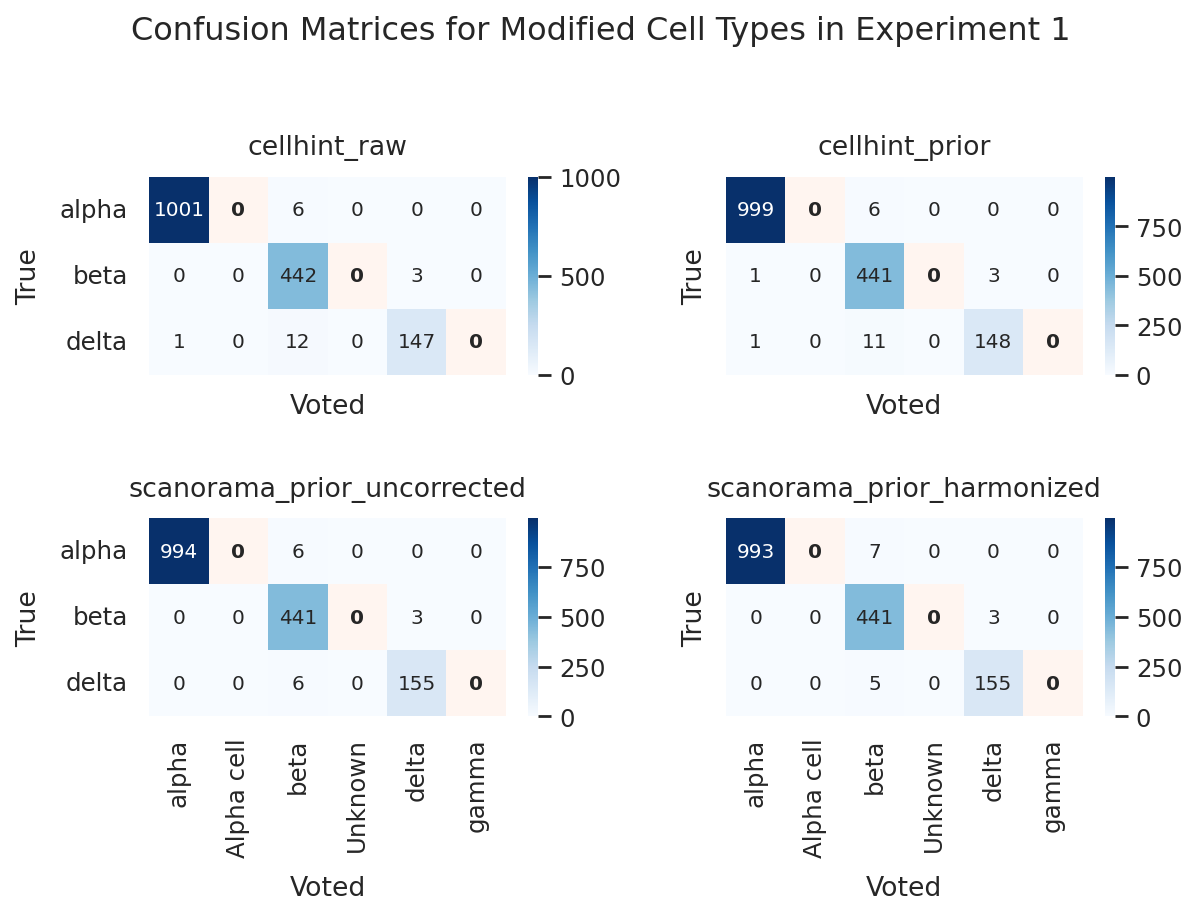

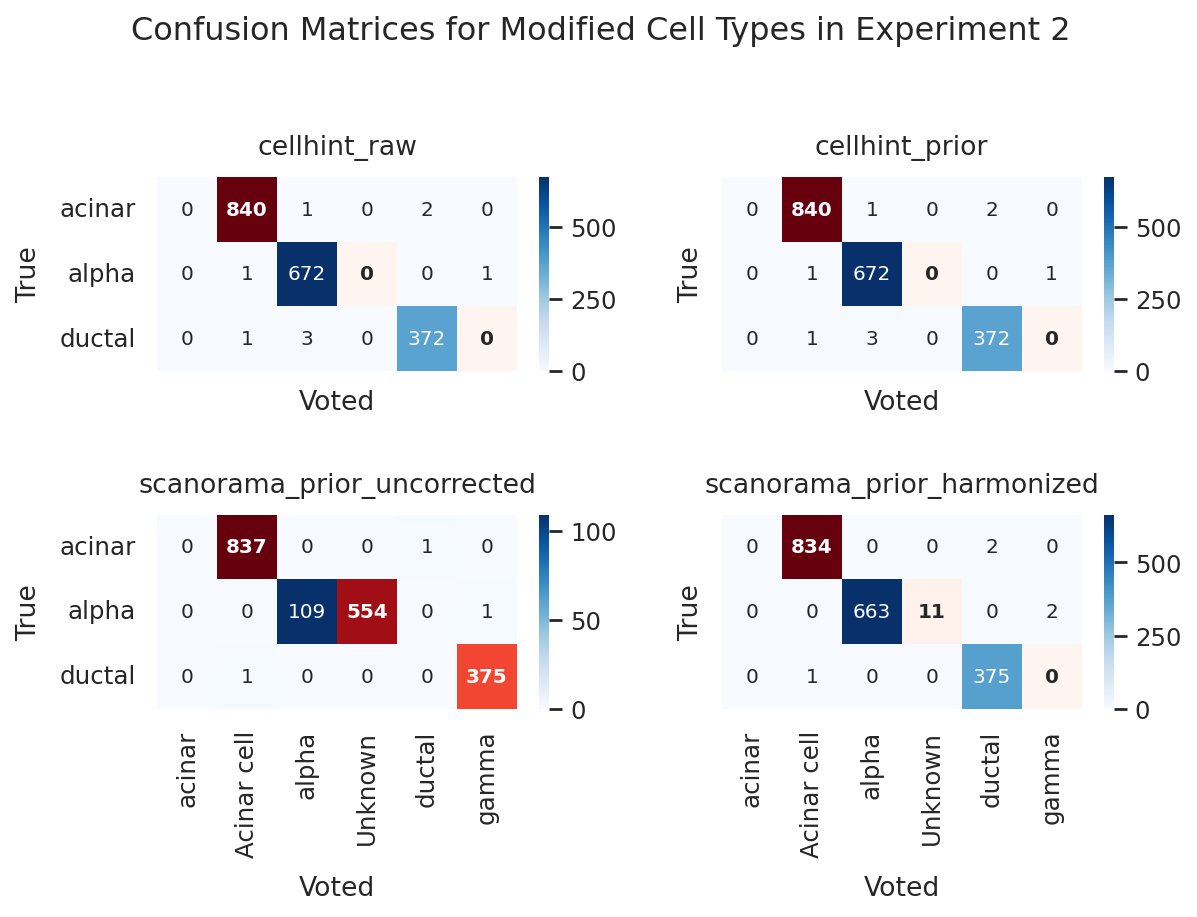

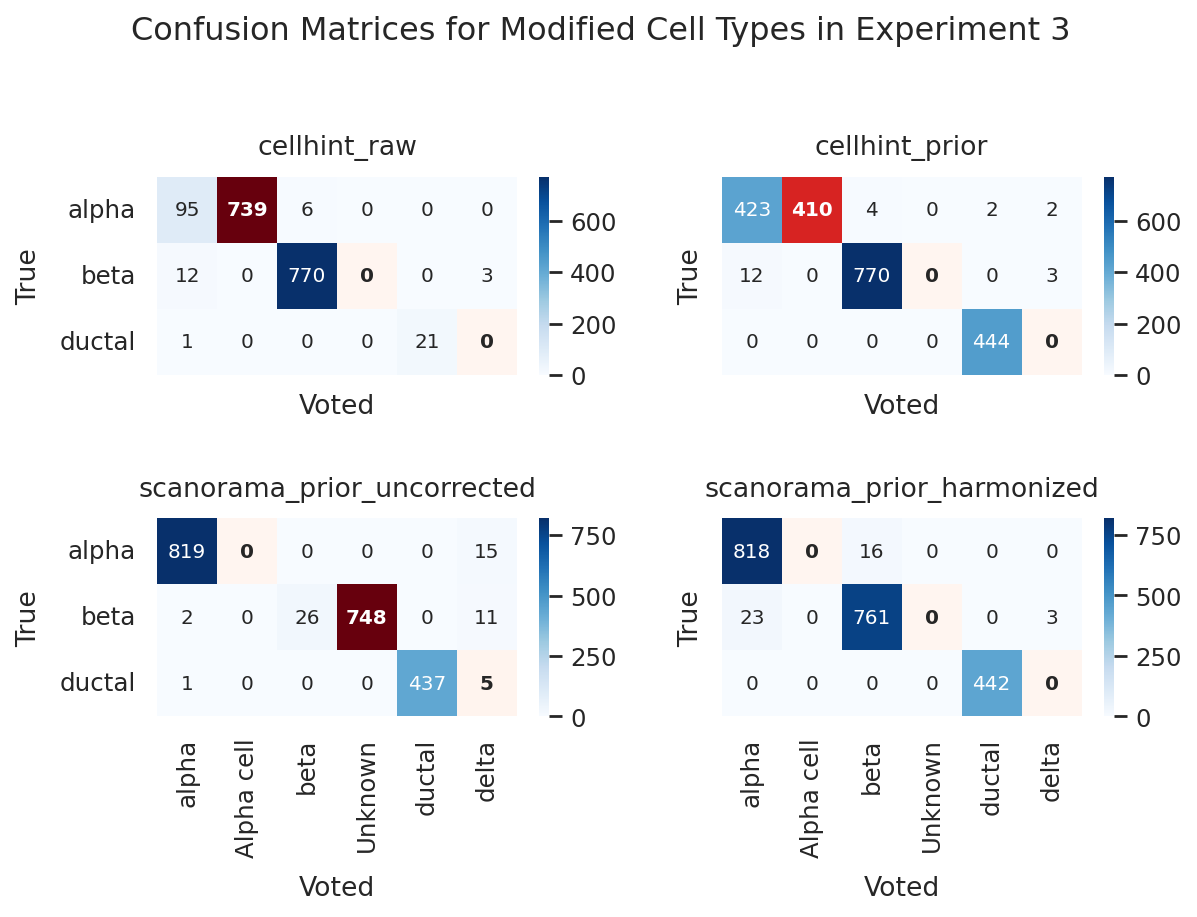

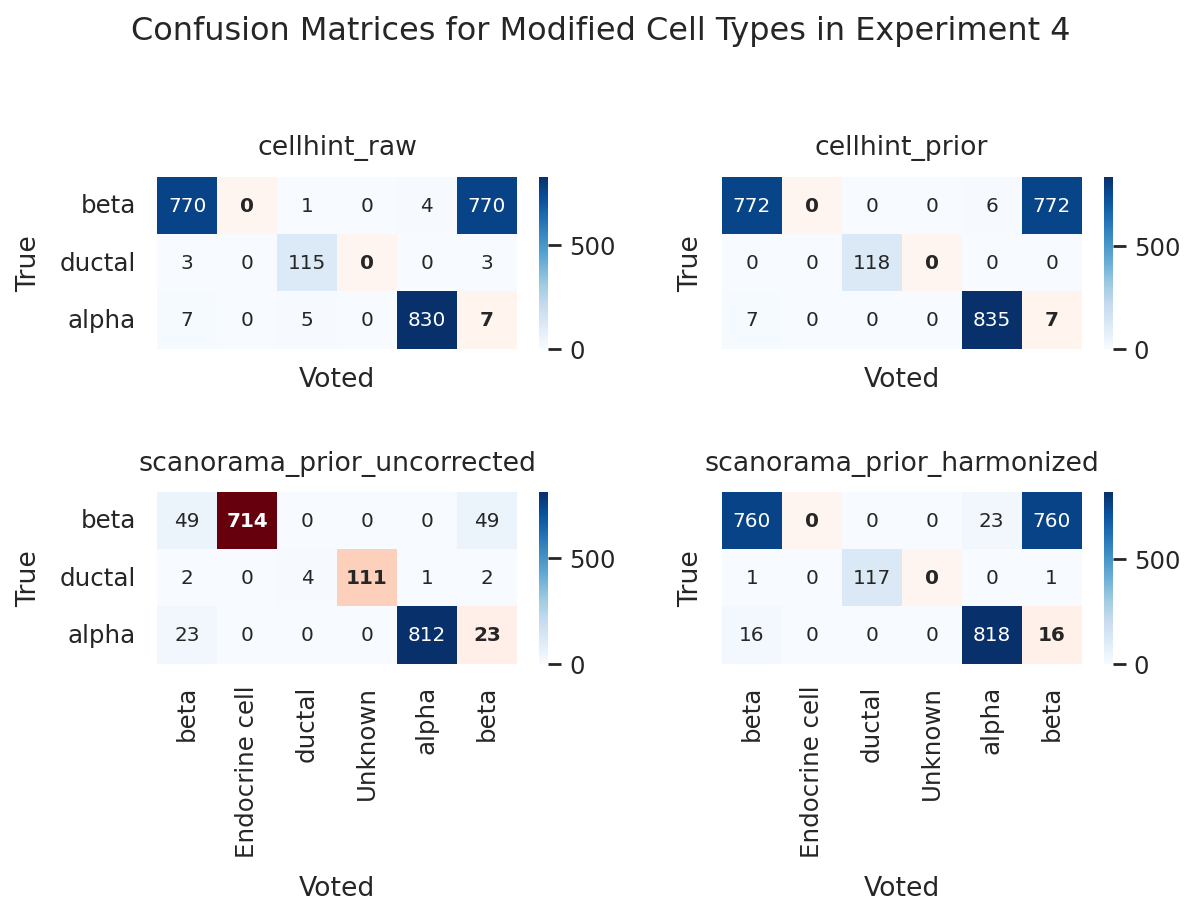

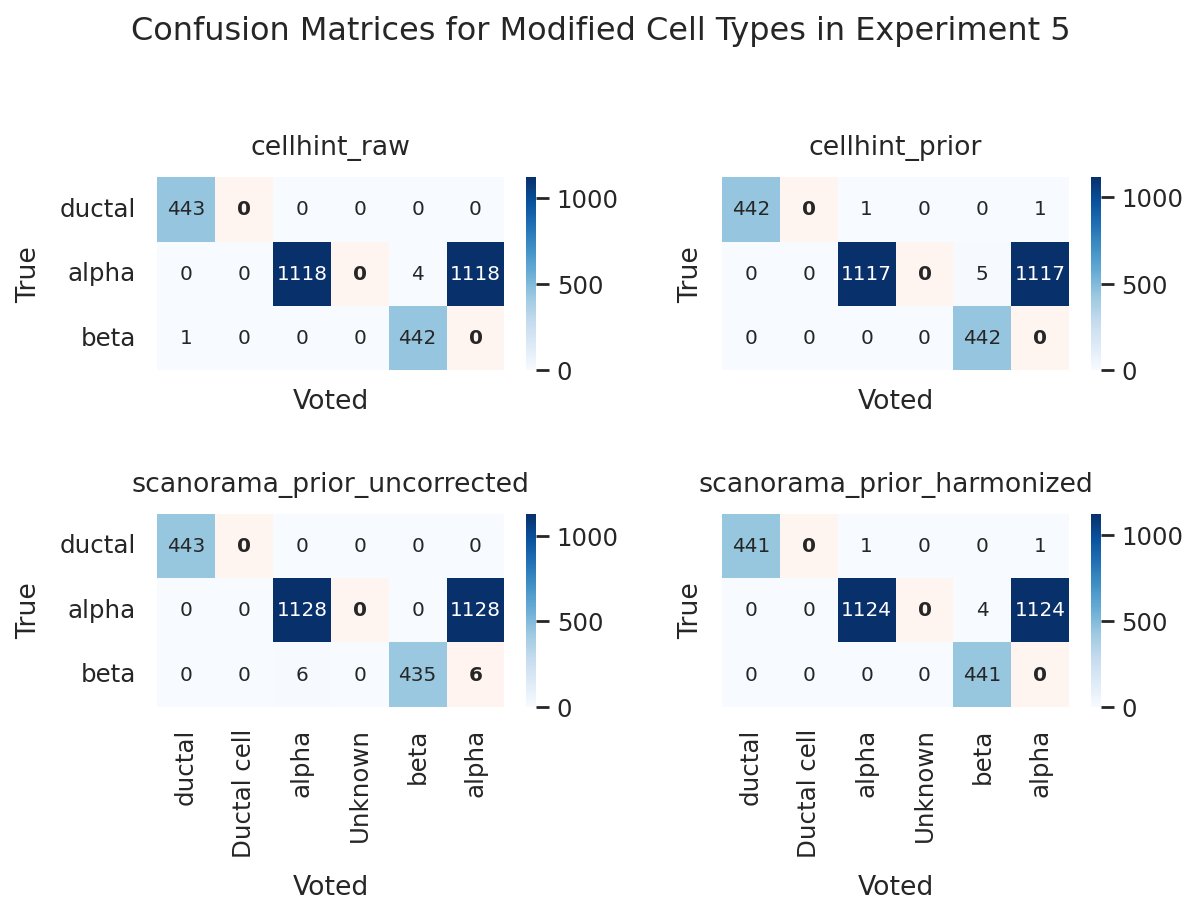

In [35]:
for i in range(experimental_table.shape[0]-1):
    raw_adata = sc.read(experimental_table['adata_path'][5])
    adata = sc.read(experimental_table['adata_path'][i])
    changed_cell_type_list = eval(experimental_table['label_changes'][i])
    ct_dataset = [item[0] for item in changed_cell_type_list]
    ct_from = [item[1] for item in changed_cell_type_list]
    ct_to = []
    for item in changed_cell_type_list:
        ct_to.append(item[1])
        ct_to.append(item[2])
        
    embedding_leiden_pairs = [
        ('X_umap_cellhint_raw', 'leiden_cellhint_raw'),
        ('X_umap_cellhint_prior', 'leiden_cellhint_prior'),
        ('X_umap_scanorama_prior_uncorrected', 'leiden_scanorama_prior_uncorrected'),
        ('X_umap_scanorama_prior_harmonized', 'leiden_scanorama_prior_harmonized'),
        # ('X_umap_scanorama_raw', 'leiden_scanorama_raw'),
    ]

    # Create subplot grid based on number of methods
    n_methods = len(embedding_leiden_pairs)
    n_cols = 2
    n_rows = (n_methods + n_cols - 1) // n_cols

    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 3*n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for idx, (emb_key, leiden_key) in enumerate(embedding_leiden_pairs):
        adata = major_vote_cluster_labels(
            adata=adata,
            leiden_key=leiden_key,
            changed_label_key='changed_cell_type',
            true_label_key='real_cell_type'
        )
        
        mask = pd.Index([])
        for dataset, ct in zip(ct_dataset, ct_from):
            indices = adata.obs[(adata.obs['study'] == dataset) & 
                            (adata.obs['real_cell_type'] == ct)].index
            mask = mask.union(indices)
        df = adata.obs.loc[mask, ['real_cell_type', 'voted_labels']]
        cm = pd.crosstab(df['real_cell_type'], df['voted_labels'])
        cm = cm.reindex(columns=ct_to, fill_value=0)
        cm = cm.loc[ct_from]
        row_labels = cm.index
        
        mask = np.zeros_like(cm, dtype=bool)
        edge_colors = np.zeros(cm.shape + (3,))
        for row_idx in range(len(cm)):
            col_idx = 2 * row_idx + 1
            if col_idx < cm.shape[1]:
                mask[row_idx, col_idx] = True
                
        sns.heatmap(
            cm, 
            ax=axes[idx],
            annot=True,
            fmt='d',
            cmap='Blues',
            annot_kws={'size': 9},
            cbar=True,
            mask=mask,
        )

        vmin, vmax = cm.min().min(), cm.max().max()
        sns.heatmap(
            cm,
            ax=axes[idx],
            annot=True,
            fmt='d',
            cmap='Reds',
            cbar=False,
            vmin=vmin,
            vmax=vmax * 0.75,
            annot_kws={'size': 9, 'weight': 'bold'},
            mask=~mask,
        )
        
        axes[idx].set_title(emb_key.replace('X_umap_', ''), pad=10)
        axes[idx].set_xlabel('Voted', labelpad=8)
        axes[idx].set_ylabel('True', labelpad=8)
        axes[idx].set_yticklabels(row_labels, rotation=0)
        
    # Remove empty subplots
    for idx in range(n_methods, len(axes)):
        fig.delaxes(axes[idx])

    plt.suptitle(f'Confusion Matrices for Modified Cell Types in Experiment {i+1}')
    plt.tight_layout(pad=2.0)
    plt.savefig(f'figures/fig4/confusion_matrices_modified_cell_types_exp{i+1}.pdf', bbox_inches='tight')
    plt.show()

# Plot umap

In [36]:
# from statannotations.Annotator import Annotator
sc.set_figure_params(vector_friendly=True, dpi_save=600) 

In [50]:
ct_from

['acinar', 'alpha', 'ductal']

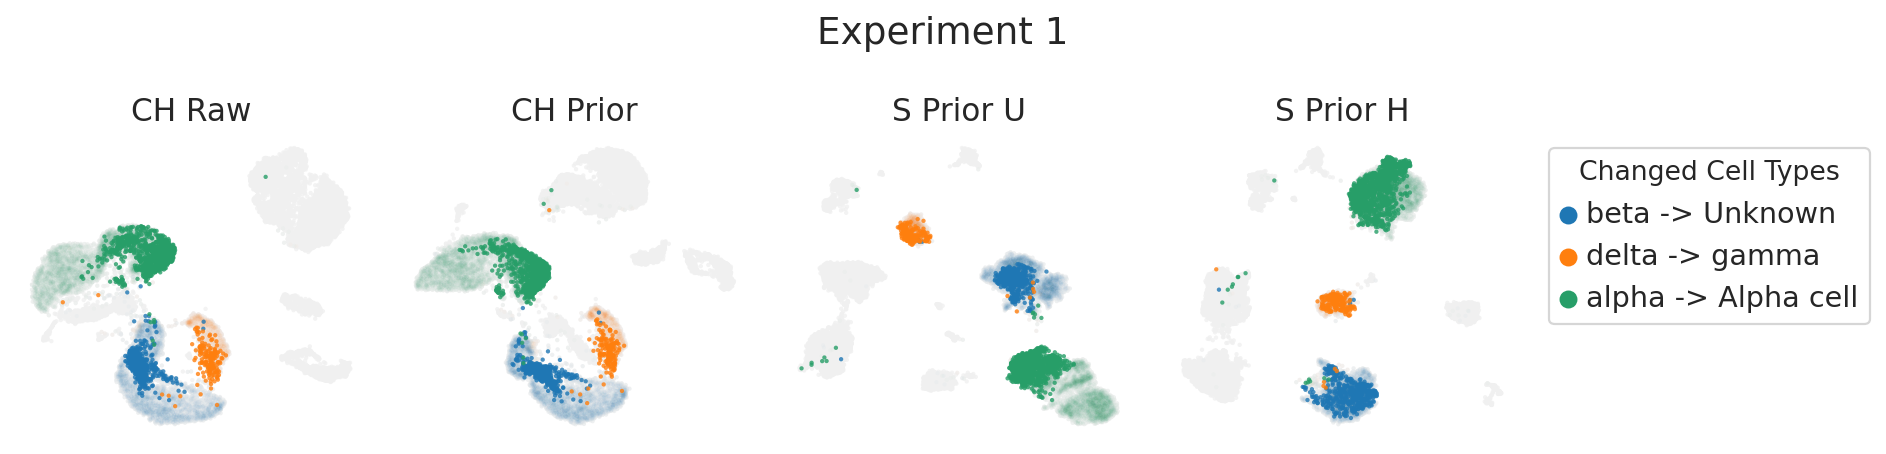

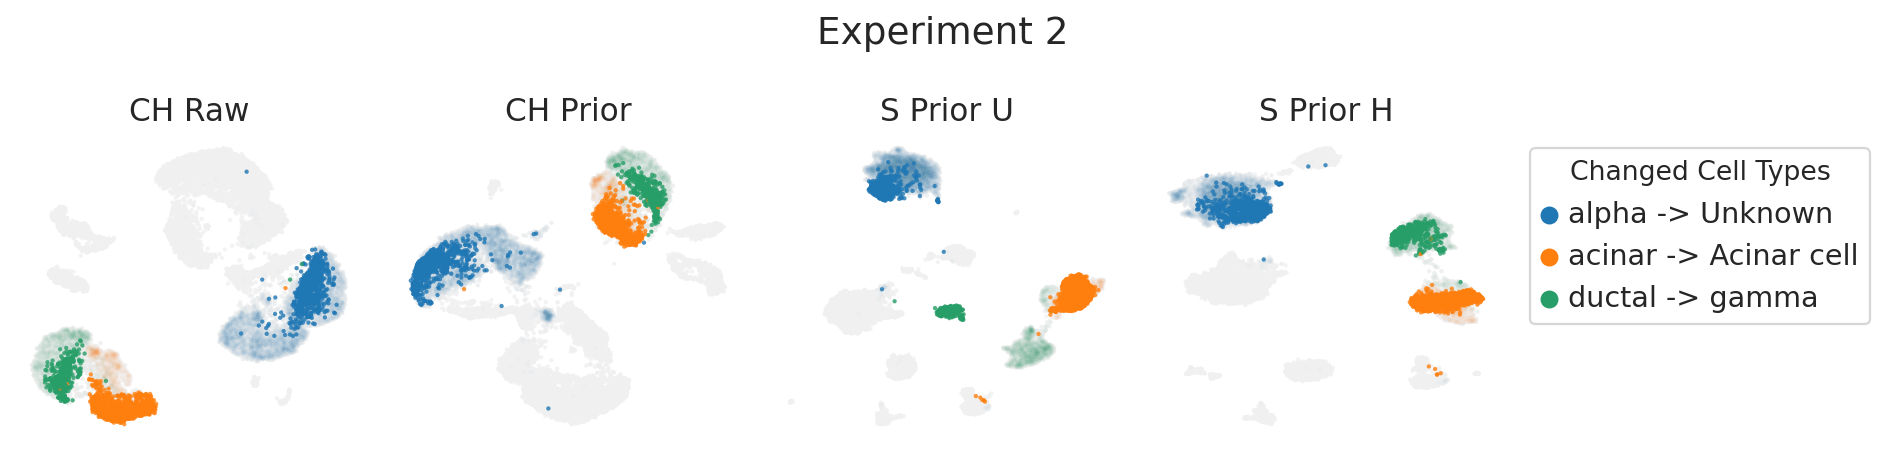

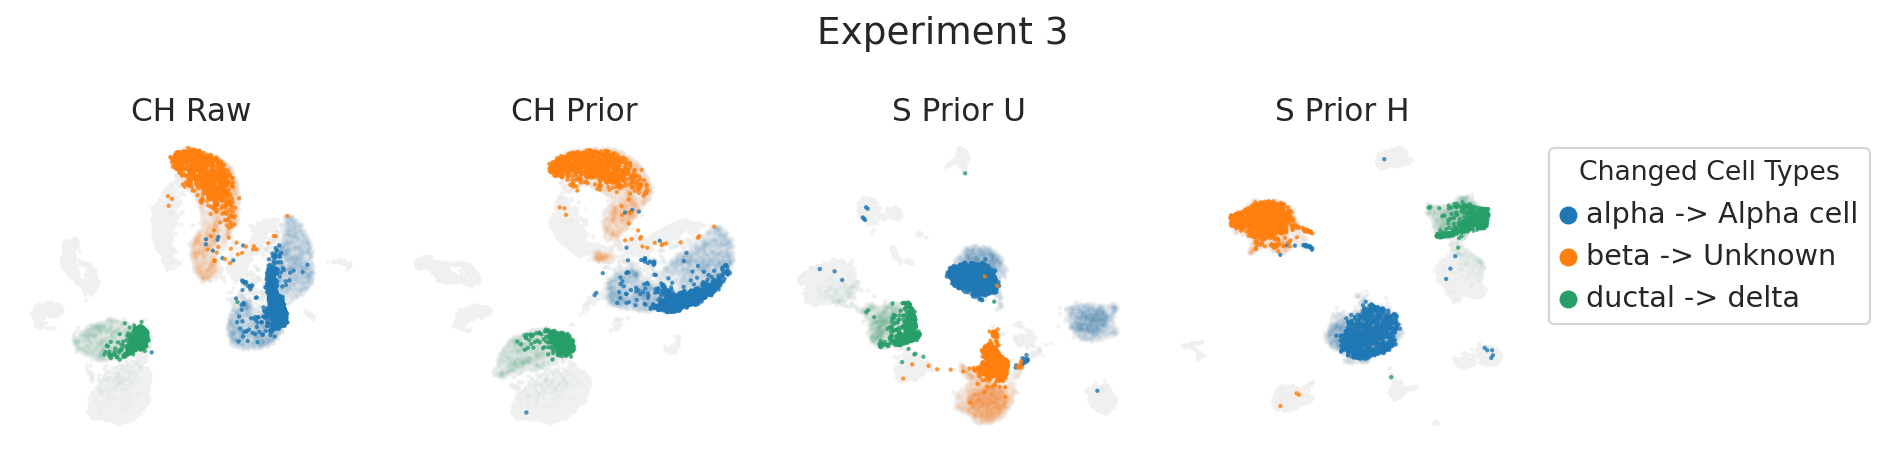

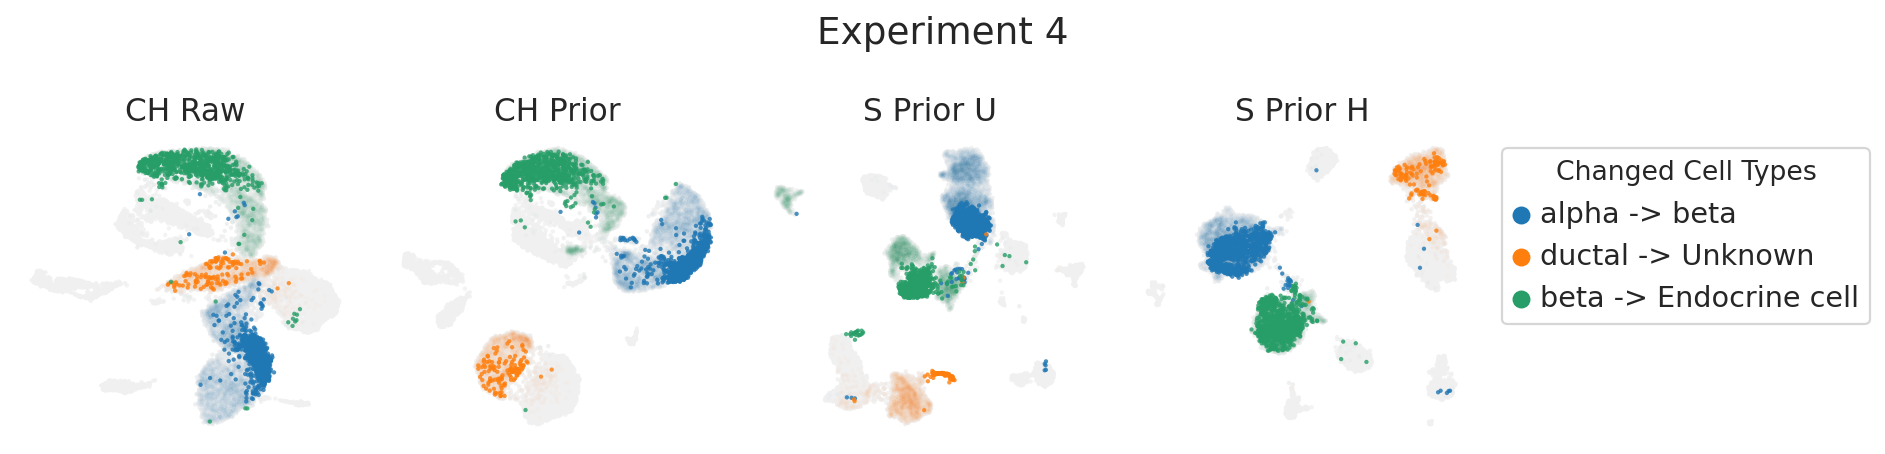

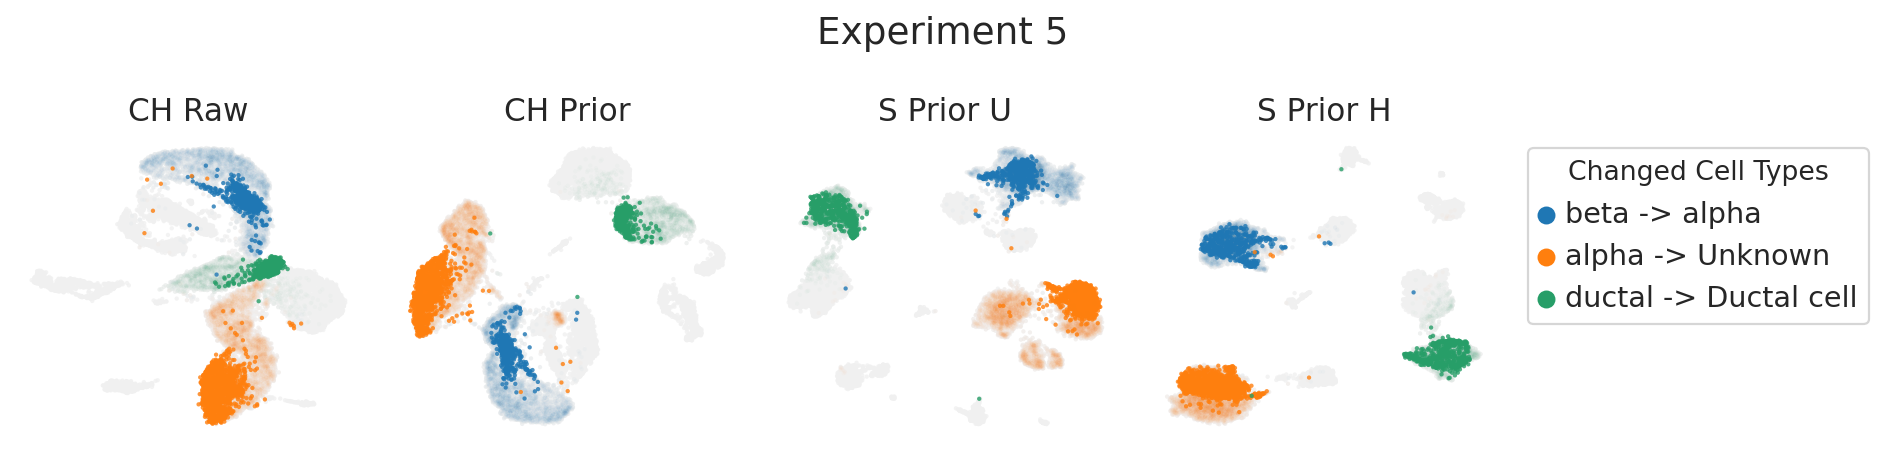

In [54]:
for i in range(experimental_table.shape[0]-1):
    adata = sc.read(experimental_table['adata_path'][i]).copy()
    changed_cell_type_list = eval(experimental_table['label_changes'][i])
    dict_changed_to_from = {}
    for item in changed_cell_type_list:
        dict_changed_to_from[item[2]] = item[1]
    ct_dataset = [item[0] for item in changed_cell_type_list]
    ct_from = [item[1] for item in changed_cell_type_list]
    ct_to = []
    for item in changed_cell_type_list:
        ct_to.append(item[1])
        ct_to.append(item[2])
        
    embedding_leiden_pairs = [
        ('X_umap_cellhint_raw', 'leiden_cellhint_raw'),
        ('X_umap_cellhint_prior', 'leiden_cellhint_prior'),
        ('X_umap_scanorama_prior_uncorrected', 'leiden_scanorama_prior_uncorrected'),
        ('X_umap_scanorama_prior_harmonized', 'leiden_scanorama_prior_harmonized'),
    ]
    
    # Create mask
    mask_cells = pd.Series(False, index=adata.obs.index)
    for dataset, ct in zip(ct_dataset, ct_from):
        mask = (adata.obs['study'] == dataset) & (adata.obs['real_cell_type'] == ct)
        mask_cells = mask_cells | mask
    
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    
    # Get color mapping for changed cell types
    highlight_adata = adata[mask_cells].copy()
    unique_changed_types = highlight_adata.obs['changed_cell_type'].unique()
    colors = sc.pl.palettes.default_20[:]
    color_dict = {ct: colors[i] for i, ct in enumerate(unique_changed_types)}
    
    # Map original cell types to their future changed types for coloring
    original_to_changed = {}
    for dataset, from_type, to_type in changed_cell_type_list:
        original_to_changed[(dataset, from_type)] = to_type
    
    embedding_names = ['CH Raw', 'CH Prior', 'S Prior U', 'S Prior H']
    adata.obs['background'] = 'background'
    for ax, (emb_key, leiden_key), name in zip(axes, embedding_leiden_pairs, embedding_names):
        # Background cells (non-emphasized)
        background_adata = adata[~mask_cells].copy()
        sc.pl.embedding(
            background_adata,
            basis=emb_key,
            ax=ax,
            show=False,
            frameon=False,
            size=15,
            alpha=0.8,
            legend_loc=None,
            color='background',
            palette={'background': '#f0f0f0'},
        )
        
        # Original cells that will be changed (low alpha)
        for dataset, from_type in zip(ct_dataset, ct_from):
            mask = (adata.obs['real_cell_type'] == from_type)
            if mask.any():
                original_cells = adata[mask].copy()
                changed_type = original_to_changed[(dataset, from_type)]
                sc.pl.embedding(
                    original_cells,
                    basis=emb_key,
                    ax=ax,
                    show=False,
                    frameon=False,
                    size=15,
                    alpha=0.02,  # Lower alpha for original cells
                    legend_loc=None,
                    color='real_cell_type',
                    palette={from_type: color_dict[changed_type]},
                )
        
        # Emphasized cells
        sc.pl.embedding(
            highlight_adata,
            basis=emb_key,
            title=name,
            color='changed_cell_type',
            ax=ax,
            show=False,
            frameon=False,
            size=15,
            alpha=0.8,
            legend_loc=None,
            palette=color_dict,
        )
        
        # Legend
        legend_elements = [
            plt.scatter([], [], c=colors[i], label=ct, s=50)
            for i, ct in enumerate(unique_changed_types)
        ]
        
        if ax == axes[-1]:
            ax.legend(handles=legend_elements,
                    labels=[dict_changed_to_from[x] + ' -> ' + x for x in unique_changed_types],
                    title='Changed Cell Types',
                    bbox_to_anchor=(1.05, 1),
                    loc='upper left')
            
    plt.suptitle(f'Experiment {i+1}', y=0.95)
    plt.tight_layout()
    plt.savefig(f'figures/fig4/umaps_changed_cell_types_exp{i+1}.pdf', bbox_inches='tight')
    plt.show()